# Kalman Filter

In [19]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import matplotlib.mlab as mlab
%matplotlib inline

### Gaussian Function

In [9]:
def gaussian(mu, sigma2, x):
    return 1/sqrt(2*pi*sigma2) * exp(-0.5 * (x - mu)**2 / sigma2)

gaussian(10, 4, 8)

0.12098536225957168

## Measurement step

In [10]:
def update(mean1, var1, mean2, var2):
    new_mean = (mean1*var2 + mean2*var1)/(var1+var2)
    new_var = 1/(1/var1 + 1/var2)
    return [new_mean, new_var]

update(10, 8, 13, 2)

[12.4, 1.6]

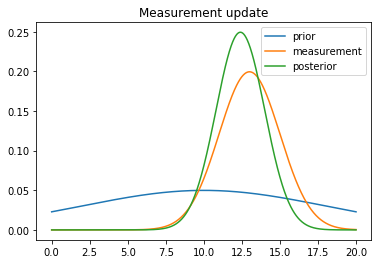

In [23]:
x = np.linspace(0, 20, 1000)
plt.plot(x,norm.pdf(x, 10, 8))
plt.plot(x,norm.pdf(x, 13, 2))
plt.plot(x,norm.pdf(x, 12.4, 1.6))
plt.title('Measurement update')
plt.legend(['prior', 'measurement', 'posterior'])
plt.show()

## Motion (Prediction) Step

In [24]:
def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

predict(10, 4, 12, 4)

[22, 8]

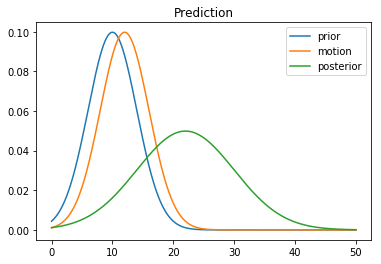

In [26]:
x = np.linspace(0, 50, 1000)
plt.plot(x,norm.pdf(x, 10, 4))
plt.plot(x,norm.pdf(x, 12, 4))
plt.plot(x,norm.pdf(x, 22, 8))
plt.title('Prediction')
plt.legend(['prior', 'motion', 'posterior'])
plt.show()

## Combined Kalman Filter 

In [38]:
# data
measurements = [5., 6., 7., 9., 10.]
motion = [1., 1., 2., 1., 1.]
measurement_sig = 4.
motion_sig = 2.
mu = 0.
sig = 10000.

In [39]:
output_save = []
output_save.append((mu, sig))

for m, u in zip(measurements, motion):
    mu, sig = update(mu, sig, m, measurement_sig)
    mu, sig = predict(mu, sig, u, motion_sig)
    output_save.append((mu, sig))
print(mu, sig)

10.999906177177365 4.005861580844194


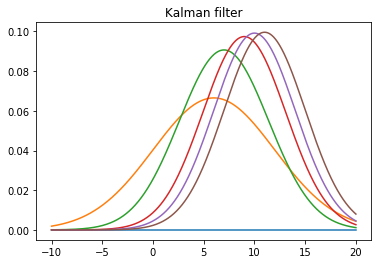

In [43]:
x = np.linspace(-10, 20, 1000)
for m, s in output_save:
    plt.plot(x,norm.pdf(x, m, s))
plt.title('Kalman filter')
plt.show()

## Kalman Filter (Multidimension)

In [1]:
class matrix:
    
    # implements basic operations of a matrix class
    
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        self.dimy = len(value[0])
        if value == [[]]:
            self.dimx = 0
    
    def zero(self, dimx, dimy):
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx = dimx
            self.dimy = dimy
            self.value = [[0 for row in range(dimy)] for col in range(dimx)]
    
    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise ValueError("Invalid size of matrix")
        else:
            self.dimx = dim
            self.dimy = dim
            self.value = [[0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1
    
    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')
    
    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to add")
        else:
            # add if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res
    
    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise ValueError("Matrices must be of equal dimensions to subtract")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res
    
    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise ValueError("Matrices must be m*n and n*p to multiply")
        else:
            # multiply if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
            return res
    
    def transpose(self):
        # compute transpose
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res
    
    # Thanks to Ernesto P. Adorio for use of Cholesky and CholeskyInverse functions
    
    def Cholesky(self, ztol=1.0e-5):
        # Computes the upper triangular Cholesky factorization of
        # a positive definite matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise ValueError("Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(self.dimx)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise ValueError("Zero diagonal")
        return res
    
    def CholeskyInverse(self):
        # Computes inverse of matrix given its Cholesky upper Triangular
        # decomposition of matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/tjj**2 - S/tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = -sum([self.value[i][k]*res.value[k][j] for k in range(i+1, self.dimx)])/self.value[i][i]
        return res
    
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res
    
    def __repr__(self):
        return repr(self.value)


In [25]:
def kalman_filter(x, P):
    for n in range(len(measurements)):
        # measurement update
        Z = matrix([[measurements[n]]])
        y = Z - (H * x)
        S = H * P * H.transpose() + R
        K = P * H.transpose() * S.inverse()
        x = x + (K * y)
        P = (I - K * H) * P

        # prediction
        x = F * x + u
        P = F * P * F.transpose()
        
    return x,P

############################################
### use the code below to test your filter!
############################################

measurements = [1, 2, 3]

x = matrix([[0.], [0.]]) # initial state (location and velocity)
P = matrix([[1000., 0.], [0., 1000.]]) # initial uncertainty
u = matrix([[0.], [0.]]) # external motion
F = matrix([[1., 1.], [0, 1.]]) # next state function
H = matrix([[1., 0.]]) # measurement function
R = matrix([[1.]]) # measurement uncertainty
I = matrix([[1., 0.], [0., 1.]]) # identity matrix

x, P = kalman_filter(x, P)
# output should be:
# x: [[3.9996664447958645], [0.9999998335552873]]
# P: [[2.3318904241194827, 0.9991676099921091], [0.9991676099921067, 0.49950058263974184]]

In [26]:
print('x:')
x.show()
print('P:')
P.show()

x:
[3.9996664447958645]
[0.9999998335552873]
 
P:
[2.3318904241194827, 0.9991676099921091]
[0.9991676099921067, 0.49950058263974184]
 
